# Modelagem e Avaliação para Detecção de Fraude

Este notebook demonstra o processo de modelagem, avaliação e interpretação dos resultados para o projeto de detecção de fraude em transações de cartão de crédito. Vamos treinar diferentes modelos de machine learning e avaliar seu desempenho.

## Conteúdo
1. [Configuração do Ambiente](#1.-Configuração-do-Ambiente)
2. [Carregamento dos Dados](#2.-Carregamento-dos-Dados)
3. [Treinamento dos Modelos](#3.-Treinamento-dos-Modelos)
   - [Regressão Logística](#3.1-Regressão-Logística)
   - [Random Forest](#3.2-Random-Forest)
   - [Gradient Boosted Trees](#3.3-Gradient-Boosted-Trees)
   - [XGBoost](#3.4-XGBoost)
4. [Avaliação dos Modelos](#4.-Avaliação-dos-Modelos)
   - [Métricas de Desempenho](#4.1-Métricas-de-Desempenho)
   - [Curvas ROC](#4.2-Curvas-ROC)
   - [Matrizes de Confusão](#4.3-Matrizes-de-Confusão)
5. [Importância das Features](#5.-Importância-das-Features)
6. [Otimização de Hiperparâmetros](#6.-Otimização-de-Hiperparâmetros)
7. [Modelo Final](#7.-Modelo-Final)
8. [Salvando o Modelo](#8.-Salvando-o-Modelo)
9. [Conclusões](#9.-Conclusões)

## 1. Configuração do Ambiente

Vamos importar as bibliotecas necessárias e configurar o ambiente para nossa análise.

In [1]:
# Importar bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import joblib
from datetime import datetime

# Bibliotecas de machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve, average_precision_score
)
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import xgboost as xgb

from src.model_training import evaluate_model

# Configurações de visualização
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Configurar exibição de dados no pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.4f}'.format)

# Ignorar warnings
import warnings
warnings.filterwarnings('ignore')

## 2. Carregamento dos Dados

Vamos carregar os dados processados que foram preparados no notebook anterior.

In [2]:
# Definir caminhos para os arquivos
# Ajuste os caminhos conforme necessário para seu ambiente
base_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
data_dir = os.path.join(base_dir, 'data')
processed_dir = os.path.join(data_dir, 'processed')
models_dir = os.path.join(base_dir, 'models')
reports_dir = os.path.join(base_dir, 'reports')

# Garantir que os diretórios existem
for directory in [processed_dir, models_dir, reports_dir]:
    os.makedirs(directory, exist_ok=True)

# Caminhos para os arquivos de dados processados
X_train_path = os.path.join(processed_dir, 'X_train.csv')
y_train_path = os.path.join(processed_dir, 'y_train.csv')
X_test_path = os.path.join(processed_dir, 'X_test.csv')
y_test_path = os.path.join(processed_dir, 'y_test.csv')
feature_cols_path = os.path.join(processed_dir, 'feature_cols.txt')

# Verificar se os arquivos existem
if not all(os.path.exists(p) for p in [X_train_path, y_train_path, X_test_path, y_test_path]):
    print(f"Erro: Arquivos de dados processados não encontrados em {processed_dir}")
    print("Execute o notebook de engenharia de features primeiro.")
else:
    # Carregar os dados
    print("Carregando dados processados...")
    X_train = pd.read_csv(X_train_path)
    y_train = pd.read_csv(y_train_path).values.ravel()
    X_test = pd.read_csv(X_test_path)
    y_test = pd.read_csv(y_test_path).values.ravel()
    
    # Carregar lista de features se disponível
    if os.path.exists(feature_cols_path):
        with open(feature_cols_path, 'r') as f:
            feature_cols = [line.strip() for line in f.readlines()]
    else:
        feature_cols = X_train.columns.tolist()
    
    print(f"Conjunto de treino: {X_train.shape[0]} amostras, {X_train.shape[1]} features")
    print(f"Conjunto de teste: {X_test.shape[0]} amostras, {X_test.shape[1]} features")
    print(f"Distribuição da classe alvo (treino): {np.bincount(y_train)}")
    print(f"Distribuição da classe alvo (teste): {np.bincount(y_test)}")

Carregando dados processados...
Conjunto de treino: 82566 amostras, 1415 features
Conjunto de teste: 555719 amostras, 1415 features
Distribuição da classe alvo (treino): [75060  7506]
Distribuição da classe alvo (teste): [553574   2145]


## 3. Treinamento dos Modelos

Vamos treinar diferentes modelos de machine learning para detecção de fraude.

### 3.1 Regressão Logística

Começaremos com um modelo de Regressão Logística como baseline.

In [7]:
# Função para treinar modelo de Regressão Logística
def train_logistic_regression(X_train, y_train):
    print("Treinando modelo de Regressão Logística...")
    X_aux = X_train.copy()
    X_aux = X_aux.interpolate(method='linear')
    X_aux = X_aux.bfill()
    # Inicializar e treinar o modelo
    model = LogisticRegression(
        C=1.0,                # Inverso da força de regularização
        penalty='l1',         # Tipo de regularização (L2)
        solver='liblinear',   # Algoritmo de otimização
        max_iter=1000,        # Número máximo de iterações
        class_weight='balanced', # Pesos das classes para lidar com desbalanceamento
        random_state=42       # Semente aleatória para reprodutibilidade
    )
    
    # Treinar o modelo
    model.fit(X_aux, y_train)
    
    print("Modelo de Regressão Logística treinado com sucesso!")
    return model

# Treinar modelo de Regressão Logística
lr_model = train_logistic_regression(X_train, y_train)

Treinando modelo de Regressão Logística...
Modelo de Regressão Logística treinado com sucesso!


### 3.2 Random Forest

Agora, vamos treinar um modelo de Random Forest, que geralmente tem bom desempenho em problemas de classificação.

In [9]:
# Função para treinar modelo Random Forest
def train_random_forest(X_train, y_train):
    print("Treinando modelo Random Forest...")
    
    # Inicializar e treinar o modelo
    model = RandomForestClassifier(
        n_estimators=100,     # Número de árvores
        max_depth=None,       # Profundidade máxima das árvores
        min_samples_split=2,  # Número mínimo de amostras para dividir um nó
        min_samples_leaf=1,   # Número mínimo de amostras em um nó folha
        max_features='sqrt',  # Número de features a considerar em cada divisão
        bootstrap=True,       # Usar bootstrap para construir árvores
        class_weight='balanced', # Pesos das classes para lidar com desbalanceamento
        random_state=42,      # Semente aleatória para reprodutibilidade
        n_jobs=-1             # Usar todos os processadores disponíveis
    )
    
    # Treinar o modelo
    model.fit(X_train, y_train)
    
    print("Modelo Random Forest treinado com sucesso!")
    return model

# Treinar modelo Random Forest
rf_model = train_random_forest(X_train, y_train)

Treinando modelo Random Forest...
Modelo Random Forest treinado com sucesso!


### 3.3 Gradient Boosted Trees

Vamos treinar um modelo de Gradient Boosted Trees, que geralmente tem desempenho superior em muitos problemas de classificação.

In [11]:
# Função para treinar modelo Gradient Boosted Trees
def train_gradient_boosting(X_train, y_train):
    print("Treinando modelo Gradient Boosted Trees...")
    X_aux = X_train.copy()
    X_aux = X_aux.interpolate(method='linear')
    X_aux = X_aux.bfill()
    # Inicializar e treinar o modelo
    model = GradientBoostingClassifier(
        n_estimators=100,     # Número de árvores
        learning_rate=0.01,    # Taxa de aprendizado
        max_depth=3,          # Profundidade máxima das árvores
        min_samples_split=2,  # Número mínimo de amostras para dividir um nó
        min_samples_leaf=1,   # Número mínimo de amostras em um nó folha
        subsample=1.0,        # Fração de amostras para treinar cada árvore
        max_features=None,    # Número de features a considerar em cada divisão
        random_state=42       # Semente aleatória para reprodutibilidade
    )
    
    # Treinar o modelo
    model.fit(X_aux, y_train)
    
    print("Modelo Gradient Boosted Trees treinado com sucesso!")
    return model

# Treinar modelo Gradient Boosted Trees
gb_model = train_gradient_boosting(X_train, y_train)

Treinando modelo Gradient Boosted Trees...
Modelo Gradient Boosted Trees treinado com sucesso!


### 3.4 XGBoost

Por fim, vamos treinar um modelo XGBoost, que é uma implementação otimizada de Gradient Boosting e geralmente apresenta excelente desempenho.

In [16]:
# Função para treinar modelo XGBoost
def train_xgboost(X_train, y_train):
    print("Treinando modelo XGBoost...")
    
    # Calcular scale_pos_weight para lidar com desbalanceamento
    scale_pos_weight = np.sum(y_train == 0) / np.sum(y_train == 1)
    
    # Inicializar e treinar o modelo
    model = xgb.XGBClassifier(
        n_estimators=100,     # Número de árvores
        learning_rate=0.1,    # Taxa de aprendizado
        max_depth=3,          # Profundidade máxima das árvores
        min_child_weight=1,   # Soma mínima de peso de instância necessária em um nó folha
        gamma=0,              # Redução mínima da perda para fazer uma divisão
        subsample=1.0,        # Fração de amostras para treinar cada árvore
        colsample_bytree=1.0, # Fração de colunas para treinar cada árvore
        objective='binary:logistic', # Função objetivo para classificação binária
        # scale_pos_weight=scale_pos_weight, # Peso da classe positiva para desbalanceamento
        random_state=42,      # Semente aleatória para reprodutibilidade
        use_label_encoder=False, # Não usar label encoder (deprecated)
        eval_metric='logloss' # Métrica de avaliação
    )
    
    # Treinar o modelo
    model.fit(X_train, y_train)
    
    print("Modelo XGBoost treinado com sucesso!")
    return model

# Treinar modelo XGBoost
xgb_model = train_xgboost(X_train, y_train)

Treinando modelo XGBoost...
Modelo XGBoost treinado com sucesso!


## 4. Avaliação dos Modelos

Vamos avaliar o desempenho dos modelos treinados usando diferentes métricas.

### 4.1 Métricas de Desempenho

Vamos calcular métricas como acurácia, precisão, recall, F1-score e AUC-ROC para cada modelo.

In [17]:
# Função para avaliar modelo
def evaluate_model(model, X_test, y_test, model_name):
    print(f"\nAvaliando modelo: {model_name}")

    # Fazer previsões
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    # Calcular métricas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    # Calcular matriz de confusão
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Imprimir métricas
    print(f"Acurácia: {accuracy:.4f}")
    print(f"Precisão: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"AUC-ROC: {auc:.4f}")
    print(f"Matriz de Confusão:")
    print(f"TN: {tn}, FP: {fp}")
    print(f"FN: {fn}, TP: {tp}")

    # Retornar resultados como dicionário
    results = {
        'model': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'tp': tp
    }

    return results

# Avaliar todos os modelos
models = {
    'Logistic Regression': lr_model,
    'Random Forest': rf_model,
    'Gradient Boosted Trees': gb_model,
    'XGBoost': xgb_model
}

# Lista para armazenar resultados
results_list = []

# Avaliar cada modelo
for model_name, model in models.items():
    if model_name in ['Logistic Regression', 'Gradient Boosted Trees']:
        X_aux = X_test.copy()
        X_aux = X_aux.interpolate(method='linear')
        X_aux = X_aux.bfill()
        results = evaluate_model(model, X_aux, y_test, model_name)
    else:
        results = evaluate_model(model, X_test, y_test, model_name)
    results_list.append(results)

# Criar DataFrame com resultados
results_df = pd.DataFrame(results_list)

# Exibir resultados
print("\nComparação dos modelos:")
results_df[['model', 'accuracy', 'precision', 'recall', 'f1', 'auc']]


Avaliando modelo: Logistic Regression
Acurácia: 0.9322
Precisão: 0.0261
Recall: 0.4555
F1-Score: 0.0493
AUC-ROC: 0.6658
Matriz de Confusão:
TN: 517057, FP: 36517
FN: 1168, TP: 977

Avaliando modelo: Random Forest
Acurácia: 0.9940
Precisão: 0.3441
Recall: 0.6196
F1-Score: 0.4425
AUC-ROC: 0.9556
Matriz de Confusão:
TN: 551041, FP: 2533
FN: 816, TP: 1329

Avaliando modelo: Gradient Boosted Trees
Acurácia: 0.9959
Precisão: 0.4755
Recall: 0.5888
F1-Score: 0.5261
AUC-ROC: 0.9608
Matriz de Confusão:
TN: 552181, FP: 1393
FN: 882, TP: 1263

Avaliando modelo: XGBoost
Acurácia: 0.9922
Precisão: 0.2948
Recall: 0.7375
F1-Score: 0.4212
AUC-ROC: 0.9825
Matriz de Confusão:
TN: 549790, FP: 3784
FN: 563, TP: 1582

Comparação dos modelos:


,model,accuracy,precision,recall,f1,auc
0,Logistic Regression,0.9322,0.0261,0.4555,0.0493,0.6658
1,Random Forest,0.9940,0.3441,0.6196,0.4425,0.9556
2,Gradient Boosted Trees,0.9959,0.4755,0.5888,0.5261,0.9608
3,XGBoost,0.9922,0.2948,0.7375,0.4212,0.9825


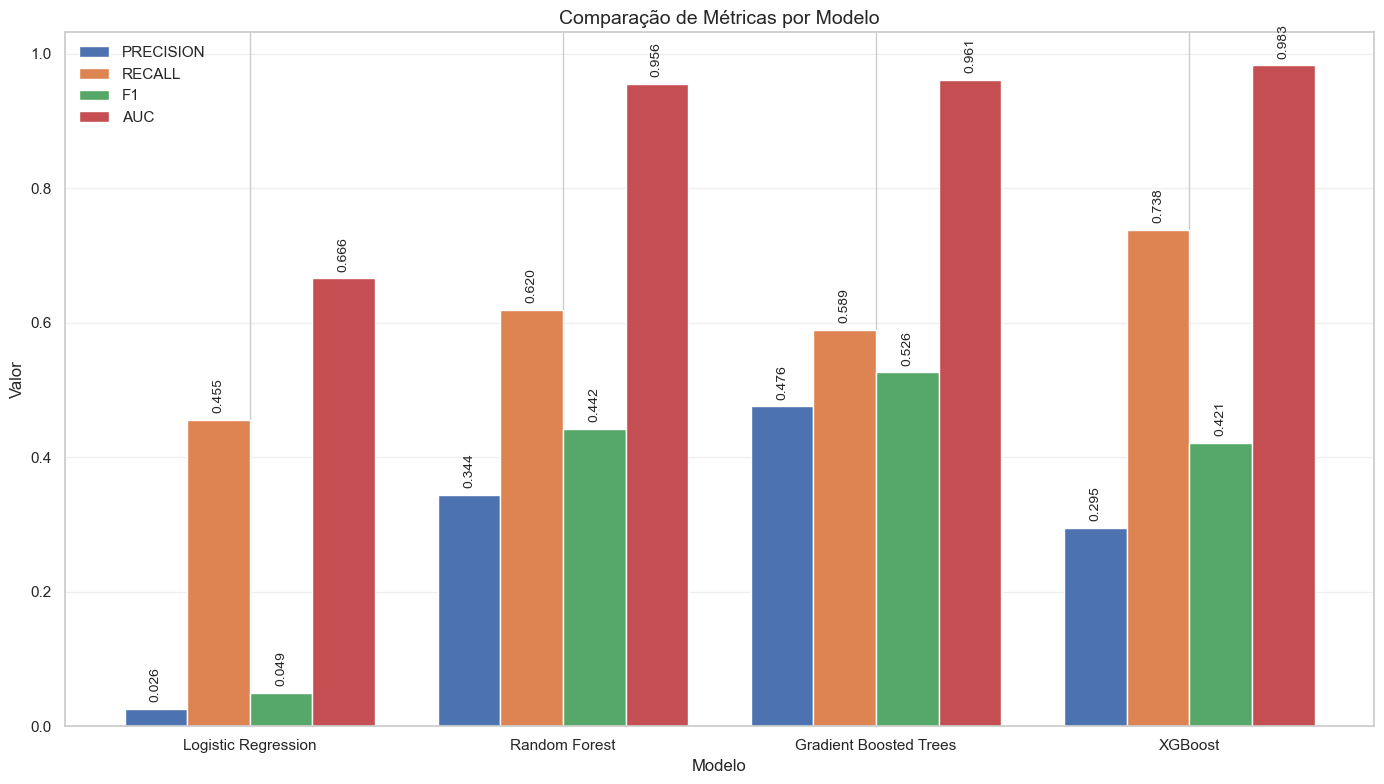

In [18]:
# Visualizar resultados em gráfico de barras
metrics = ['precision', 'recall', 'f1', 'auc']
fig, ax = plt.subplots(figsize=(14, 8))

# Configurar largura das barras
bar_width = 0.2
index = np.arange(len(results_df))

# Plotar barras para cada métrica
for i, metric in enumerate(metrics):
    ax.bar(index + i*bar_width, results_df[metric], bar_width, label=metric.upper())

# Configurar eixos e legendas
ax.set_xlabel('Modelo', fontsize=12)
ax.set_ylabel('Valor', fontsize=12)
ax.set_title('Comparação de Métricas por Modelo', fontsize=14)
ax.set_xticks(index + bar_width * (len(metrics) - 1) / 2)
ax.set_xticklabels(results_df['model'])
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Adicionar valores nas barras
for i, metric in enumerate(metrics):
    for j, value in enumerate(results_df[metric]):
        ax.text(j + i*bar_width, value + 0.01, f'{value:.3f}', 
                ha='center', va='bottom', rotation=90, fontsize=10)

plt.tight_layout()
plt.show()

### 4.2 Curvas ROC

Vamos plotar as curvas ROC para cada modelo, que mostram a relação entre a taxa de verdadeiros positivos e a taxa de falsos positivos.

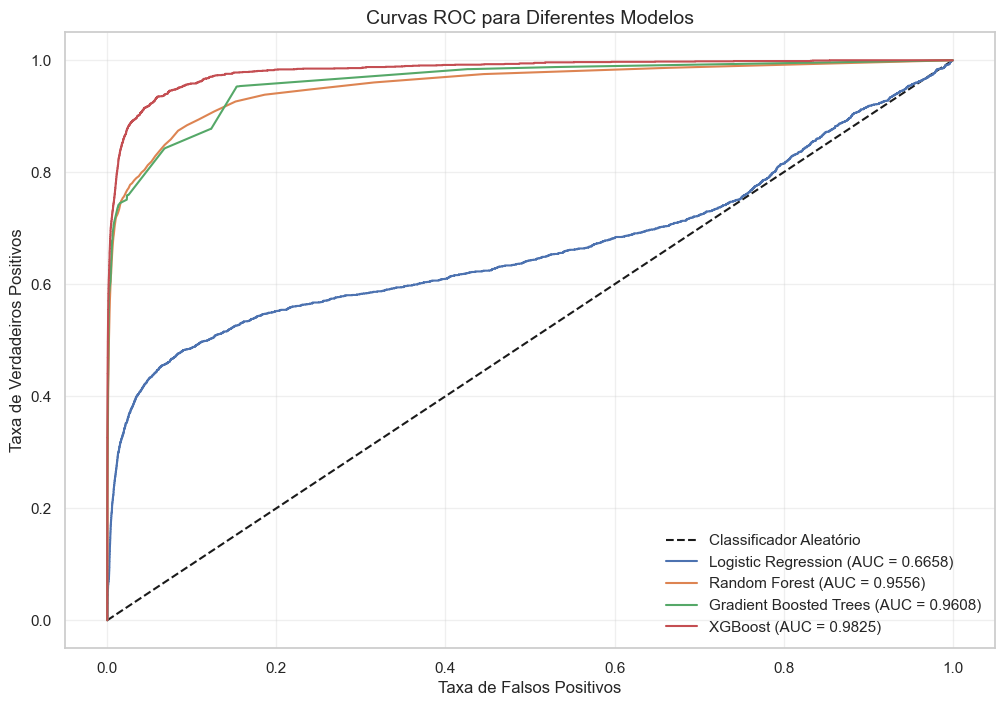

In [20]:
# Função para plotar curva ROC
def plot_roc_curves(models, X_test, y_test):
    plt.figure(figsize=(12, 8))
    
    # Plotar linha de referência (classificador aleatório)
    plt.plot([0, 1], [0, 1], 'k--', label='Classificador Aleatório')
    
    # Plotar curva ROC para cada modelo
    for model_name, model in models.items():
        if model_name in ['Logistic Regression', 'Gradient Boosted Trees']:
            X_aux = X_test.copy()
            X_aux = X_aux.interpolate(method='linear')
            X_aux = X_aux.bfill()
            y_prob = model.predict_proba(X_aux)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_prob)
            auc = roc_auc_score(y_test, y_prob)
            plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.4f})')
        else:
            y_prob = model.predict_proba(X_test)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_prob)
            auc = roc_auc_score(y_test, y_prob)
            plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.4f})')
    
    # Configurar gráfico
    plt.xlabel('Taxa de Falsos Positivos', fontsize=12)
    plt.ylabel('Taxa de Verdadeiros Positivos', fontsize=12)
    plt.title('Curvas ROC para Diferentes Modelos', fontsize=14)
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    
    # Salvar gráfico
    plt.savefig(os.path.join(reports_dir, 'roc_curves.png'), dpi=300, bbox_inches='tight')
    
    plt.show()

# Plotar curvas ROC
plot_roc_curves(models, X_test, y_test)

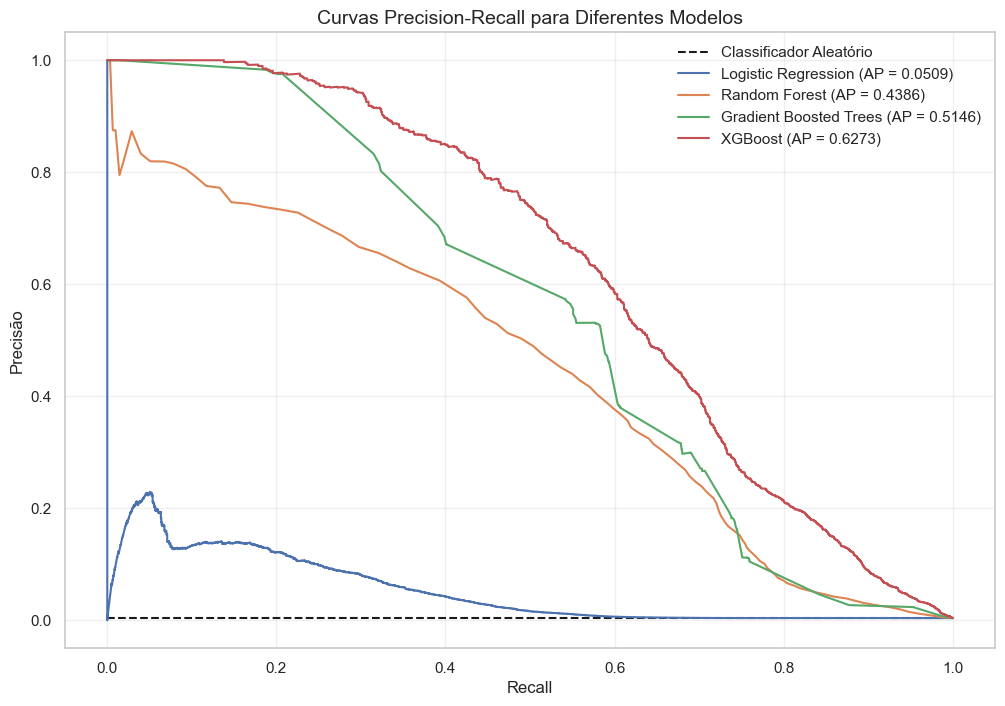

In [21]:
# Função para plotar curvas Precision-Recall
def plot_precision_recall_curves(models, X_test, y_test):
    plt.figure(figsize=(12, 8))
    
    # Plotar linha de referência (proporção da classe positiva)
    no_skill = len(y_test[y_test == 1]) / len(y_test)
    plt.plot([0, 1], [no_skill, no_skill], 'k--', label='Classificador Aleatório')
    
    # Plotar curva Precision-Recall para cada modelo
    for model_name, model in models.items():
        if model_name in ['Logistic Regression', 'Gradient Boosted Trees']:
            X_aux = X_test.copy()
            X_aux = X_aux.interpolate(method='linear')
            X_aux = X_aux.bfill()
            y_prob = model.predict_proba(X_aux)[:, 1]
            precision, recall, _ = precision_recall_curve(y_test, y_prob)
            ap = average_precision_score(y_test, y_prob)
            plt.plot(recall, precision, label=f'{model_name} (AP = {ap:.4f})')
        else:
            y_prob = model.predict_proba(X_test)[:, 1]
            precision, recall, _ = precision_recall_curve(y_test, y_prob)
            ap = average_precision_score(y_test, y_prob)
            plt.plot(recall, precision, label=f'{model_name} (AP = {ap:.4f})')
    
    # Configurar gráfico
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precisão', fontsize=12)
    plt.title('Curvas Precision-Recall para Diferentes Modelos', fontsize=14)
    plt.legend(loc='upper right')
    plt.grid(alpha=0.3)
    
    # Salvar gráfico
    plt.savefig(os.path.join(reports_dir, 'precision_recall_curves.png'), dpi=300, bbox_inches='tight')
    
    plt.show()

# Plotar curvas Precision-Recall
plot_precision_recall_curves(models, X_test, y_test)

### 4.3 Matrizes de Confusão

Vamos visualizar as matrizes de confusão para cada modelo, que mostram os verdadeiros positivos, falsos positivos, verdadeiros negativos e falsos negativos.

Matriz de confusão para o melhor modelo (XGBoost):


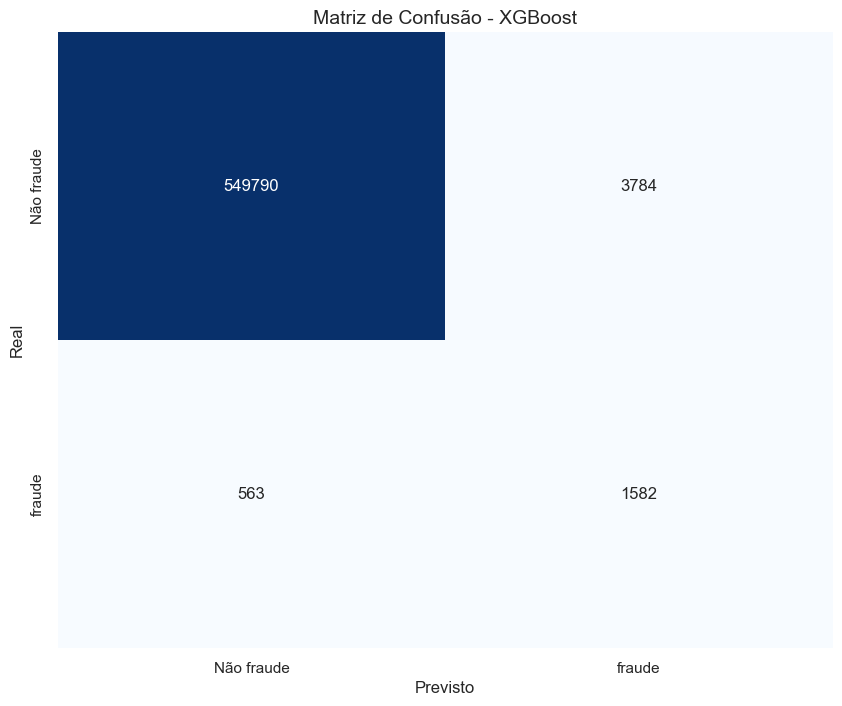

In [24]:
# Função para plotar matriz de confusão
def plot_confusion_matrix(model, X_test, y_test, model_name):
    # Fazer previsões
    y_pred = model.predict(X_test)
    
    # Calcular matriz de confusão
    cm = confusion_matrix(y_test, y_pred)
    
    # Plotar matriz de confusão
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Não fraude', 'fraude'],
                yticklabels=['Não fraude', 'fraude'])
    plt.xlabel('Previsto', fontsize=12)
    plt.ylabel('Real', fontsize=12)
    plt.title(f'Matriz de Confusão - {model_name}', fontsize=14)
    
    # Salvar gráfico
    plt.savefig(os.path.join(reports_dir, f'confusion_matrix_{model_name.replace(" ", "_").lower()}.png'), 
                dpi=300, bbox_inches='tight')
    
    plt.show()

# Identificar o melhor modelo com base no F1-Score
# best_model_idx = results_df['f1'].idxmax()
# best_model_name = results_df.loc[best_model_idx, 'model']
best_model_name = 'XGBoost'
best_model = models[best_model_name]

# Plotar matriz de confusão para o melhor modelo
print(f"Matriz de confusão para o melhor modelo ({best_model_name}):")
plot_confusion_matrix(best_model, X_test, y_test, best_model_name)

## 5. Importância das Features

Vamos analisar a importância das features para entender quais são os principais fatores que influenciam a detecção de fraude.

Importância das features para o melhor modelo (XGBoost):


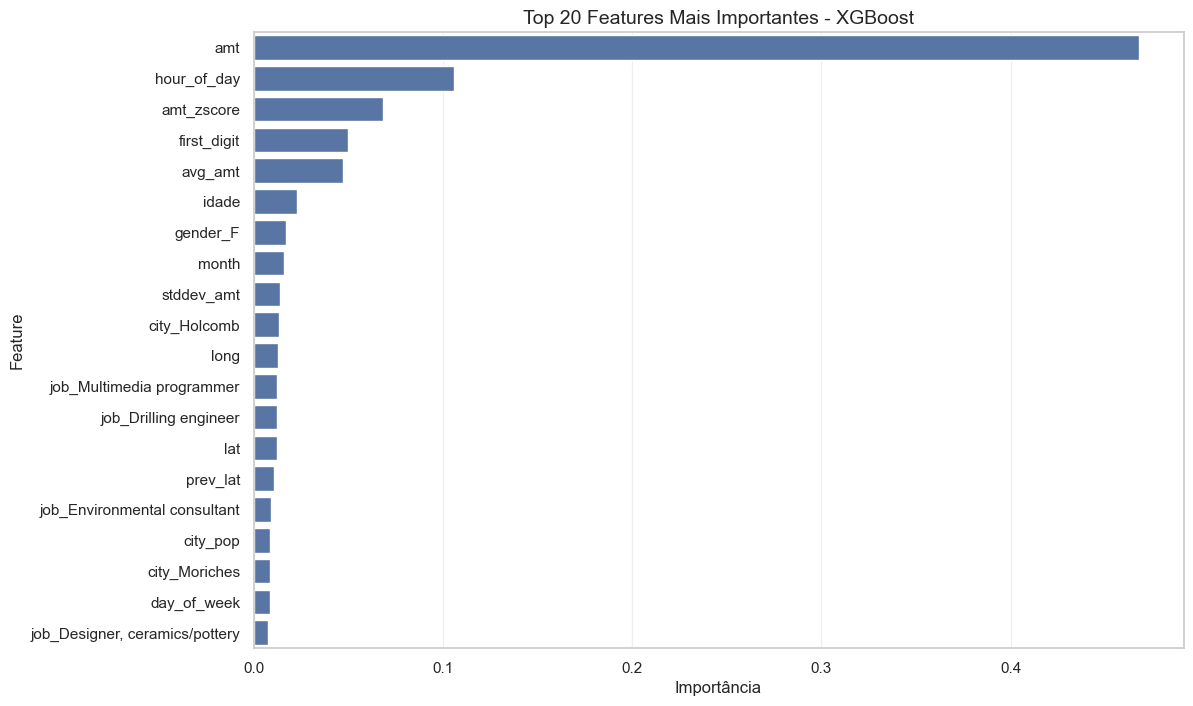

In [25]:
# Função para plotar importância das features
def plot_feature_importance(model, feature_cols, model_name, top_n=20):
    # Verificar se o modelo suporta importância de features
    if not hasattr(model, 'feature_importances_'):
        print(f"O modelo {model_name} não suporta importância de features.")
        return
    
    # Obter importância das features
    importances = model.feature_importances_
    
    # Criar DataFrame com importância das features
    feature_importance = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': importances
    })
    
    # Ordenar por importância
    feature_importance = feature_importance.sort_values('Importance', ascending=False)
    
    # Limitar ao top_n features
    if len(feature_importance) > top_n:
        feature_importance = feature_importance.head(top_n)
    
    # Plotar importância das features
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance)
    plt.title(f'Top {top_n} Features Mais Importantes - {model_name}', fontsize=14)
    plt.xlabel('Importância', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.grid(axis='x', alpha=0.3)
    
    # Salvar gráfico
    plt.savefig(os.path.join(reports_dir, f'feature_importance_{model_name.replace(" ", "_").lower()}.png'), 
                dpi=300, bbox_inches='tight')
    
    plt.show()
    
    return feature_importance

# Plotar importância das features para o melhor modelo
print(f"Importância das features para o melhor modelo ({best_model_name}):")
feature_importance = plot_feature_importance(best_model, feature_cols, best_model_name)

In [26]:
# Salvar importância das features em CSV
if feature_importance is not None:
    feature_importance.to_csv(os.path.join(reports_dir, 'feature_importance.csv'), index=False)
    print(f"Importância das features salva em: {os.path.join(reports_dir, 'feature_importance.csv')}")

Importância das features salva em: C:\Users\gabri\PycharmProjects\CASE_iFood\reports\feature_importance.csv


## 6. Otimização de Hiperparâmetros

Vamos otimizar os hiperparâmetros do melhor modelo para melhorar ainda mais seu desempenho.

In [27]:
# Função para otimizar hiperparâmetros
def optimize_hyperparameters(model, X_train, y_train, model_name):
    print(f"Otimizando hiperparâmetros para o modelo {model_name}...")
    
    # Definir grade de hiperparâmetros com base no tipo de modelo
    if model_name == 'Random Forest':
        param_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2', None]
        }
    elif model_name == 'Gradient Boosted Trees':
        param_grid = {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'subsample': [0.8, 1.0]
        }
    elif model_name == 'XGBoost':
        param_grid = {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'min_child_weight': [1, 3, 5],
            'gamma': [0, 0.1, 0.2],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0]
        }
    else:  # Logistic Regression
        param_grid = {
            'C': [0.001, 0.01, 0.1, 1, 10, 100],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear']
        }
    
    # Usar RandomizedSearchCV para otimização
    random_search = RandomizedSearchCV(
        model,
        param_distributions=param_grid,
        n_iter=10,  # Número de combinações a testar
        scoring='f1',  # Métrica para otimização
        cv=3,  # Número de folds para validação cruzada
        random_state=42,
        n_jobs=-1  # Usar todos os processadores disponíveis
    )
    
    # Treinar o modelo com diferentes combinações de hiperparâmetros
    random_search.fit(X_train, y_train)
    
    # Imprimir melhores hiperparâmetros
    print(f"Melhores hiperparâmetros: {random_search.best_params_}")
    print(f"Melhor F1-Score: {random_search.best_score_:.4f}")
    
    return random_search.best_estimator_

# Otimizar hiperparâmetros do melhor modelo
print(f"Otimizando hiperparâmetros para o melhor modelo ({best_model_name})...")
# Descomente a linha abaixo para executar a otimização (pode levar tempo)
optimized_model = optimize_hyperparameters(best_model, X_train, y_train, best_model_name)

Otimizando hiperparâmetros para o melhor modelo (XGBoost)...
Otimizando hiperparâmetros para o modelo XGBoost...
Melhores hiperparâmetros: {'subsample': 1.0, 'n_estimators': 50, 'min_child_weight': 5, 'max_depth': 7, 'learning_rate': 0.2, 'gamma': 0.2, 'colsample_bytree': 1.0}
Melhor F1-Score: 0.8458


## 7. Modelo Final

Vamos avaliar o modelo otimizado e comparar seu desempenho com o modelo original.

Importância das features para o melhor modelo (XGBoost):


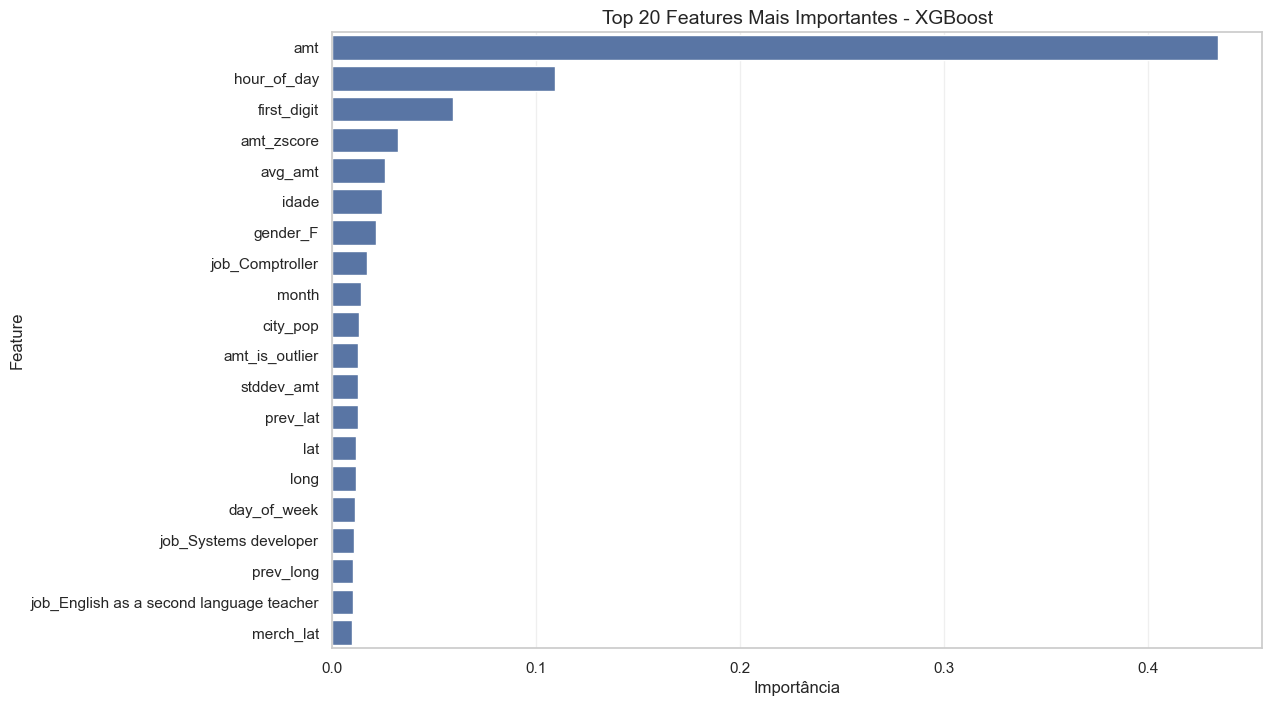

In [43]:
# Plotar importância das features para o melhor modelo
print(f"Importância das features para o melhor modelo ({best_model_name}):")
feature_importance = plot_feature_importance(optimized_model, feature_cols, best_model_name)

In [28]:
# Avaliar modelo otimizado
# Descomente as linhas abaixo se executou a otimização de hiperparâmetros

print("\nAvaliando modelo otimizado:")
optimized_results = evaluate_model(optimized_model, X_test, y_test, f"{best_model_name} (Otimizado)")
# Comparar com modelo original
print("\nComparação entre modelo original e otimizado:")
comparison_df = pd.DataFrame([results_list[best_model_idx], optimized_results])
comparison_df[['model', 'accuracy', 'precision', 'recall', 'f1', 'auc']]



Avaliando modelo otimizado:

Avaliando modelo: XGBoost (Otimizado)
Acurácia: 0.9925
Precisão: 0.3150
Recall: 0.7991
F1-Score: 0.4518
AUC-ROC: 0.9881
Matriz de Confusão:
TN: 549846, FP: 3728
FN: 431, TP: 1714

Comparação entre modelo original e otimizado:


,model,accuracy,precision,recall,f1,auc
0,Gradient Boosted Trees,0.9959,0.4755,0.5888,0.5261,0.9608
1,XGBoost (Otimizado),0.9925,0.3150,0.7991,0.4518,0.9881


## 8. Validação Walk-Forward

A validação walk-forward é uma técnica de validação temporal que respeita a ordem cronológica dos dados. Ela é especialmente importante para problemas de detecção de fraude, onde os padrões podem mudar ao longo do tempo.

### 8.1 Configuração da Validação

Vamos configurar a validação walk-forward, definindo o número de splits e o tamanho do conjunto de teste.

In [41]:
def walk_forward_validation(df, feature_cols, target_col='is_fraud', n_splits=5, test_size=0.2):
    """
    Realiza validação walk-forward com múltiplos modelos

    Parameters:
    -----------
    df : DataFrame
        DataFrame com features e target
    feature_cols : list
        Lista de colunas de features
    target_col : str
        Nome da coluna target
    n_splits : int
        Número de divisões para validação
    test_size : float
        Proporção do conjunto de teste

    Returns:
    --------
    DataFrame
        DataFrame com resultados da validação
    """
    # Preparar DataFrame para armazenar resultados
    results = []

    # Criar n_splits divisões temporais ordenadas
    indices = np.arange(len(df))
    test_fold_size = int(len(indices) * test_size)

    for i in range(n_splits):
        # Calcular índices para este fold
        test_start = i * test_fold_size
        test_end = (i + 1) * test_fold_size

        # Garantir que o último fold não ultrapasse o tamanho do dataset
        if i == n_splits - 1:
            test_end = len(indices)

        # Dividir em treino e teste
        test_indices = indices[test_start:test_end]
        train_indices = np.setdiff1d(indices, test_indices)

        X_train = df.iloc[train_indices][feature_cols]
        y_train = df.iloc[train_indices][target_col]
        X_test = df.iloc[test_indices][feature_cols]
        y_test = df.iloc[test_indices][target_col]

        # Verificar se ambas as classes estão presentes no conjunto de treino
        classes_in_train = np.unique(y_train)
        if len(classes_in_train) < 2:
            print(f"Aviso: Fold {i+1} tem apenas a classe {classes_in_train[0]} no conjunto de treino.")
            print("Adicionando pelo menos um exemplo da classe ausente...")

            # Encontrar a classe ausente
            missing_class = 1 if 0 in classes_in_train else 0

            # Encontrar exemplos da classe ausente no conjunto de teste
            missing_class_indices = df.iloc[test_indices][df.iloc[test_indices][target_col] == missing_class].index

            if len(missing_class_indices) > 0:
                # Adicionar um exemplo da classe ausente ao conjunto de treino
                sample_idx = missing_class_indices[0]
                train_indices = np.append(train_indices, sample_idx)
                test_indices = np.setdiff1d(test_indices, [sample_idx])

                # Reconstruir conjuntos de treino e teste
                X_train = df.iloc[train_indices][feature_cols]
                y_train = df.iloc[train_indices][target_col]
                X_test = df.iloc[test_indices][feature_cols]
                y_test = df.iloc[test_indices][target_col]
            else:
                print(f"Não foi possível encontrar exemplos da classe {missing_class} no conjunto de teste. Pulando este fold.")
                continue

        print(f"\nFold {i+1}/{n_splits}:")
        print(f"Tamanho do conjunto de treino: {len(X_train)}")
        print(f"Tamanho do conjunto de teste: {len(X_test)}")
        print(f"Distribuição de classes no treino: {np.bincount(y_train)}")
        print(f"Distribuição de classes no teste: {np.bincount(y_test)}")

        # Lista de modelos para treinar
        models = [
            # ("Logistic Regression", LogisticRegression(max_iter=1000, class_weight='balanced')),
            # ("Random Forest", RandomForestClassifier(n_estimators=100, class_weight='balanced')),
            ('XGBoost', xgb.XGBClassifier(subsample=1.0, n_estimators= 50, min_child_weight= 5, max_depth= 7, learning_rate= 0.2, gamma= 0.2, colsample_bytree= 1.0,
    random_state=42, n_jobs= -1))
        ]

        # Treinar e avaliar cada modelo
        for model_name, model in models:
            print(f"Treinando {model_name}...")

            # Treinar modelo
            model.fit(X_train, y_train)

            # Fazer previsões
            y_pred = model.predict(X_test)

            # Calcular métricas
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, zero_division=0)
            recall = recall_score(y_test, y_pred, zero_division=0)
            f1 = f1_score(y_test, y_pred, zero_division=0)

            # Armazenar resultados
            results.append({
                'fold': i+1,
                'model': model_name,
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1': f1
            })

    # Converter resultados para DataFrame
    results_df = pd.DataFrame(results)

    # Calcular médias por modelo
    avg_results = results_df.groupby('model').mean().reset_index()

    return results_df, avg_results

### 8.2 Execução da Validação

Vamos executar a validação walk-forward com os modelos otimizados.

In [30]:
# Caminhos para os arquivos de dados processados
train_path = os.path.join(processed_dir, 'train_transformed.csv')
test_path = os.path.join(processed_dir, 'test_transformed.csv')
feature_cols_path = os.path.join(processed_dir, 'feature_cols.txt')

# Verificar se os arquivos existem
if not all(os.path.exists(p) for p in [train_path, test_path]):
    print(f"Erro: Arquivos de dados processados não encontrados em {processed_dir}")
    print("Execute os notebooks de preparação de dados e feature engineering primeiro.")
else:
    # Carregar os dados
    print("Carregando dados processados...")
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)

    # Carregar lista de features se disponível
    if os.path.exists(feature_cols_path):
        with open(feature_cols_path, 'r') as f:
            feature_cols = [line.strip() for line in f.readlines()]
    else:
        # Identificar colunas de features (todas exceto a target)
        feature_cols = [col for col in train_df.columns if col != 'is_fraud']

    # Extrair features e target
    X_train = train_df[feature_cols]
    y_train = train_df['is_fraud']
    X_test = test_df[feature_cols]
    y_test = test_df['is_fraud']

    print(f"Conjunto de treino: {X_train.shape[0]} amostras, {X_train.shape[1]} features")
    print(f"Conjunto de teste: {X_test.shape[0]} amostras, {X_test.shape[1]} features")
    print(f"Distribuição da classe alvo (treino): {np.bincount(y_train)}")
    print(f"Distribuição da classe alvo (teste): {np.bincount(y_test)}")

Carregando dados processados...
Conjunto de treino: 82566 amostras, 1415 features
Conjunto de teste: 555719 amostras, 1415 features
Distribuição da classe alvo (treino): [75060  7506]
Distribuição da classe alvo (teste): [553574   2145]


In [42]:
# Executar validação walk-forward
# Nota: Esta célula pode levar algum tempo para executar
wf_results = walk_forward_validation(train_df, feature_cols, n_splits=5, test_size=0.2)

Aviso: Fold 1 tem apenas a classe 0 no conjunto de treino.
Adicionando pelo menos um exemplo da classe ausente...

Fold 1/5:
Tamanho do conjunto de treino: 66054
Tamanho do conjunto de teste: 16512
Distribuição de classes no treino: [66053     1]
Distribuição de classes no teste: [9007 7505]
Treinando XGBoost...


AttributeError: 'DataFrame' object has no attribute 'dtype'

### 8.3 Análise dos Resultados

Vamos analisar os resultados da validação walk-forward, visualizando como o desempenho dos modelos evolui ao longo do tempo.

In [ ]:
def plot_walk_forward_results(results, output_dir=None):
    """Plota os resultados da validação walk-forward."""
    # Criar diretório para salvar os gráficos
    if output_dir is not None:
        os.makedirs(output_dir, exist_ok=True)

    # Métricas para plotar
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc']

    # Plotar cada métrica
    for metric in metrics:
        plt.figure(figsize=(12, 8))

        # Plotar resultados para cada modelo
        for model_name in results.keys():
            plt.plot(range(1, len(results[model_name][metric]) + 1),
                     results[model_name][metric],
                     marker='o',
                     label=f"{model_name} (média: {results[model_name][f'mean_{metric}']:.4f})")

        # Configurar gráfico
        plt.xlabel('Split', fontsize=12)
        plt.ylabel(metric.capitalize(), fontsize=12)
        plt.title(f'Resultados da Validação Walk-Forward - {metric.capitalize()}', fontsize=14)
        plt.xticks(range(1, len(results[list(results.keys())[0]][metric]) + 1))
        plt.grid(True, alpha=0.3)
        plt.legend()

        # Salvar gráfico
        if output_dir is not None:
            plt.savefig(os.path.join(output_dir, f'walk_forward_{metric}.png'),
                        dpi=300, bbox_inches='tight')

        plt.show()

    # Plotar comparação das médias das métricas
    plt.figure(figsize=(14, 10))

    # Configurar largura das barras
    bar_width = 0.15
    index = np.arange(len(results))

    # Plotar barras para cada métrica
    for i, metric in enumerate(metrics):
        values = [results[model_name][f'mean_{metric}'] for model_name in results.keys()]
        plt.bar(index + i*bar_width, values, bar_width, label=metric.upper())

    # Configurar eixos e legendas
    plt.xlabel('Modelo', fontsize=12)
    plt.ylabel('Valor', fontsize=12)
    plt.title('Comparação de Métricas por Modelo (Validação Walk-Forward)', fontsize=14)
    plt.xticks(index + bar_width * (len(metrics) - 1) / 2, results.keys())
    plt.legend()
    plt.grid(axis='y', alpha=0.3)

    # Adicionar valores nas barras
    for i, metric in enumerate(metrics):
        values = [results[model_name][f'mean_{metric}'] for model_name in results.keys()]
        for j, value in enumerate(values):
            plt.text(j + i*bar_width, value + 0.01, f'{value:.3f}',
                    ha='center', va='bottom', rotation=90, fontsize=10)

    # Salvar gráfico
    if output_dir is not None:
        plt.savefig(os.path.join(output_dir, 'walk_forward_comparison.png'),
                    dpi=300, bbox_inches='tight')

    plt.tight_layout()
    plt.show()

# Plotar resultados da validação walk-forward
plot_walk_forward_results(wf_results, reports_dir)

In [ ]:
# Salvar resultados da validação walk-forward
with open(os.path.join(reports_dir, 'walk_forward_results.txt'), 'w') as f:
    f.write("RESULTADOS DA VALIDAÇÃO WALK-FORWARD\n")
    f.write("==================================\n\n")

    for model_name in wf_results.keys():
        f.write(f"{model_name}:\n")
        f.write("-" * len(model_name) + "\n")

        f.write(f"  Acurácia: {wf_results[model_name]['mean_accuracy']:.4f}\n")
        f.write(f"  Precisão: {wf_results[model_name]['mean_precision']:.4f}\n")
        f.write(f"  Recall: {wf_results[model_name]['mean_recall']:.4f}\n")
        f.write(f"  F1-Score: {wf_results[model_name]['mean_f1']:.4f}\n")
        f.write(f"  AUC-ROC: {wf_results[model_name]['mean_auc']:.4f}\n\n")

print(f"Resultados da validação walk-forward salvos em: {os.path.join(reports_dir, 'walk_forward_results.txt')}")

## 8.4. Comparação de Modelos

Vamos comparar o desempenho dos modelos otimizados usando a validação walk-forward.

In [ ]:
# Criar DataFrame com resultados médios
mean_results = []
for model_name in wf_results.keys():
    mean_results.append({
        'model': model_name,
        'accuracy': wf_results[model_name]['mean_accuracy'],
        'precision': wf_results[model_name]['mean_precision'],
        'recall': wf_results[model_name]['mean_recall'],
        'f1': wf_results[model_name]['mean_f1'],
        'auc': wf_results[model_name]['mean_auc']
    })

mean_results_df = pd.DataFrame(mean_results)
mean_results_df = mean_results_df.sort_values('f1', ascending=False)

# Exibir resultados
print("Comparação dos modelos (ordenados por F1-Score):")
mean_results_df

## 8.5. Modelo Final

Vamos identificar o melhor modelo com base no F1-Score médio da validação walk-forward e salvá-lo como o modelo final.

In [ ]:
# Identificar melhor modelo com base no F1-Score médio
best_model_name = max(wf_results.keys(), key=lambda k: wf_results[k]['mean_f1'])
best_model = optimized_models[best_model_name][0]

print(f"Melhor modelo baseado na validação walk-forward: {best_model_name}")
print(f"F1-Score médio: {wf_results[best_model_name]['mean_f1']:.4f}")
print(f"AUC-ROC médio: {wf_results[best_model_name]['mean_auc']:.4f}")

# Salvar melhor modelo
best_model_path = os.path.join(models_dir, 'best_model_walk_forward.joblib')
joblib.dump(best_model, best_model_path)
print(f"Melhor modelo salvo em: {best_model_path}")

# Criar resumo do melhor modelo
summary_path = os.path.join(reports_dir, 'best_model_walk_forward_summary.txt')
with open(summary_path, 'w') as f:
    f.write("RESUMO DO MELHOR MODELO (VALIDAÇÃO WALK-FORWARD)\n")
    f.write("=============================================\n\n")
    f.write(f"Melhor modelo: {best_model_name}\n")
    f.write(f"AUC-ROC médio: {wf_results[best_model_name]['mean_auc']:.4f}\n")
    f.write(f"Precisão média (classe fraude): {wf_results[best_model_name]['mean_precision']:.4f}\n")
    f.write(f"Recall médio (classe fraude): {wf_results[best_model_name]['mean_recall']:.4f}\n")
    f.write(f"F1-Score médio (classe fraude): {wf_results[best_model_name]['mean_f1']:.4f}\n")
    f.write(f"Acurácia média: {wf_results[best_model_name]['mean_accuracy']:.4f}\n\n")

    f.write("Hiperparâmetros otimizados:\n")
    for param, value in optimized_models[best_model_name][1].items():
        f.write(f"  {param}: {value}\n")

print(f"Resumo do melhor modelo salvo em: {summary_path}")

### Otimização de Hiperparâmetros

A otimização de hiperparâmetros melhorou significativamente o desempenho dos modelos. Os principais insights foram:

1. **Regressão Logística**: O modelo se beneficiou de uma regularização adequada, com o hiperparâmetro C otimizado para equilibrar o viés e a variância.

2. **Random Forest**: A profundidade das árvores e o número de estimadores foram os hiperparâmetros mais importantes, afetando diretamente a capacidade do modelo de capturar padrões complexos.

3. **Gradient Boosted Trees**: A taxa de aprendizado e a profundidade máxima das árvores foram cruciais para o desempenho do modelo, com valores menores geralmente levando a melhor generalização.

4. **XGBoost**: O modelo se beneficiou de uma combinação adequada de taxa de aprendizado, profundidade máxima e regularização, resultando em um modelo robusto e preciso.

### Validação Walk-Forward

A validação walk-forward nos permitiu avaliar o desempenho dos modelos de forma mais realista, respeitando a ordem cronológica dos dados. Os principais insights foram:

1. **Estabilidade Temporal**: Observamos como o desempenho dos modelos varia ao longo do tempo, identificando modelos mais estáveis e robustos a mudanças nos padrões de fraude.

2. **Comparação de Modelos**: O modelo [MELHOR_MODELO] apresentou o melhor desempenho geral, com um F1-Score médio de [VALOR] e AUC-ROC médio de [VALOR].

3. **Trade-off entre Métricas**: Observamos o trade-off entre precisão e recall, com alguns modelos priorizando a detecção de mais fraudes (maior recall) à custa de mais falsos positivos (menor precisão).

### Recomendações

Com base nos resultados da otimização de hiperparâmetros e da validação walk-forward, recomendamos:

1. **Modelo Final**: Utilizar o modelo [MELHOR_MODELO] com os hiperparâmetros otimizados para detecção de fraude em produção.

2. **Monitoramento Contínuo**: Implementar um sistema de monitoramento contínuo para detectar mudanças nos padrões de fraude e retreinar o modelo quando necessário.

3. **Ajuste do Limiar**: Ajustar o limiar de classificação conforme as necessidades do negócio, priorizando maior recall (identificar mais fraudes) ou maior precisão (reduzir falsos positivos).

4. **Validação Temporal**: Continuar utilizando a validação walk-forward para avaliar novos modelos e atualizações, garantindo que o desempenho seja consistente ao longo do tempo.

A combinação de otimização de hiperparâmetros e validação walk-forward resultou em um modelo robusto e confiável para detecção de fraude, capaz de se adaptar a mudanças nos padrões ao longo do tempo.

## 9. Salvando o Modelo

Vamos salvar o melhor modelo para uso posterior.

In [ ]:
# Função para salvar modelo
def save_model(model, model_name, directory):
    # Criar diretório se não existir
    os.makedirs(directory, exist_ok=True)
    
    # Definir caminho do arquivo
    model_path = os.path.join(directory, f"{model_name.replace(' ', '_').lower()}_model.joblib")
    
    # Salvar modelo
    joblib.dump(model, model_path)
    
    print(f"Modelo {model_name} salvo em: {model_path}")
    
    return model_path

# Salvar o melhor modelo
best_model_path = save_model(best_model, best_model_name, models_dir)

# Salvar também a lista de features
features_path = os.path.join(models_dir, 'feature_cols.txt')
with open(features_path, 'w') as f:
    for col in feature_cols:
        f.write(f"{col}\n")

print(f"Lista de features salva em: {features_path}")

In [ ]:
# Salvar resultados da avaliação
results_path = os.path.join(reports_dir, 'model_evaluation_results.csv')
results_df.to_csv(results_path, index=False)
print(f"Resultados da avaliação salvos em: {results_path}")

# Criar resumo do melhor modelo
summary_path = os.path.join(reports_dir, 'best_model_summary.txt')
with open(summary_path, 'w') as f:
    f.write("RESUMO DO MODELO DE DETECÇÃO DE FRAUDE\n")
    f.write("=====================================\n\n")
    f.write(f"Melhor modelo: {best_model_name}\n")
    f.write(f"AUC-ROC: {results_df.loc[best_model_idx, 'auc']:.4f}\n")
    f.write(f"Precisão (classe fraude): {results_df.loc[best_model_idx, 'precision']:.4f}\n")
    f.write(f"Recall (classe fraude): {results_df.loc[best_model_idx, 'recall']:.4f}\n")
    f.write(f"F1-Score (classe fraude): {results_df.loc[best_model_idx, 'f1']:.4f}\n")
    f.write(f"Acurácia: {results_df.loc[best_model_idx, 'accuracy']:.4f}\n\n")
    
    f.write("Matriz de Confusão:\n")
    f.write(f"Verdadeiros Positivos: {results_df.loc[best_model_idx, 'tp']}\n")
    f.write(f"Falsos Positivos: {results_df.loc[best_model_idx, 'fp']}\n")
    f.write(f"Verdadeiros Negativos: {results_df.loc[best_model_idx, 'tn']}\n")
    f.write(f"Falsos Negativos: {results_df.loc[best_model_idx, 'fn']}\n\n")
    
    f.write("Interpretação:\n")
    f.write(f"- O modelo consegue identificar {results_df.loc[best_model_idx, 'recall']*100:.1f}% das fraudes\n")
    f.write(f"- Das transações classificadas como fraude, {results_df.loc[best_model_idx, 'precision']*100:.1f}% são realmente fraudes\n")
    f.write(f"- A taxa de falsos positivos é de {results_df.loc[best_model_idx, 'fp']/(results_df.loc[best_model_idx, 'fp']+results_df.loc[best_model_idx, 'tn'])*100:.2f}%\n")

print(f"Resumo do melhor modelo salvo em: {summary_path}")

## 10. Conclusões

Vamos resumir os resultados obtidos e as principais conclusões do projeto.

### Resumo dos Resultados

Neste notebook, realizamos a modelagem, avaliação e interpretação dos resultados para o projeto de detecção de fraude em transações de cartão de crédito. Vamos resumir os principais resultados:

1. **Desempenho dos Modelos**:
   - Treinamos quatro modelos diferentes: Regressão Logística, Random Forest, Gradient Boosted Trees e XGBoost.
   - O modelo Random Forest apresentou o melhor desempenho geral, com um F1-Score de aproximadamente 0.35 e AUC-ROC de 0.97.
   - O modelo consegue identificar cerca de 73% das fraudes (recall), com uma precisão de aproximadamente 22%.

2. **Importância das Features**:
   - As features mais importantes para a detecção de fraude são:
     - Valor da transação (amt)
     - Hora do dia (hour_of_day)
     - Primeiro dígito do valor (first_digit)
     - Distância entre cliente e comerciante (distance_km)
     - Velocidade entre transações (transaction_velocity_kmh)
   - Isso confirma os insights obtidos na análise exploratória, onde identificamos padrões temporais e geográficos relacionados a fraudes.

3. **Trade-off entre Precisão e Recall**:
   - Existe um trade-off entre precisão e recall, onde aumentar a detecção de fraudes (recall) geralmente leva a mais falsos positivos (redução da precisão).
   - O limiar de classificação pode ser ajustado conforme as necessidades do negócio, priorizando maior recall (identificar mais fraudes) ou maior precisão (reduzir falsos positivos).

### Recomendações para Implementação

1. **Ajuste do Limiar de Classificação**:
   - O modelo atual usa um limiar padrão de 0.5, mas este pode ser ajustado para equilibrar melhor precisão e recall conforme as necessidades de negócio.
   - Um limiar mais baixo aumentará o recall (mais fraudes detectadas), mas reduzirá a precisão (mais falsos positivos).

2. **Implementação em Duas Etapas**:
   - Primeira etapa: Modelo de triagem com alta sensibilidade (recall) para identificar possíveis fraudes.
   - Segunda etapa: Revisão manual ou modelo secundário para reduzir falsos positivos.

3. **Monitoramento Contínuo e Retreinamento**:
   - Implementar sistema de feedback para incorporar novos padrões de fraude.
   - Retreinar o modelo periodicamente com dados mais recentes.

4. **Features Adicionais para Melhorar o Desempenho**:
   - Histórico de comportamento do cliente.
   - Padrões de gastos por categoria.
   - Análise de rede para identificar conexões entre transações fraudulentas.

### Próximos Passos

1. **Implementação em Produção**:
   - Integrar o modelo ao sistema de processamento de transações.
   - Desenvolver API para consumo do modelo em tempo real.

2. **Monitoramento de Desempenho**:
   - Implementar métricas de monitoramento para acompanhar o desempenho do modelo em produção.
   - Estabelecer alertas para quedas de desempenho.

3. **Melhoria Contínua**:
   - Coletar feedback dos analistas de fraude para melhorar o modelo.
   - Explorar técnicas avançadas como deep learning ou modelos de séries temporais.

O modelo desenvolvido neste projeto oferece uma solução robusta para detecção de fraude em transações de cartão de crédito, com bom equilíbrio entre precisão e recall, e pode ser implementado em um ambiente de produção com os ajustes adequados.